This jupyter-notebook has be created with 'jupytext'.

Use this [Link](https://colab.research.google.com/github/magnumnp/magnumnp_demos/blob/main/rkky.ipynb) to directly open the Notebook in Google Colab.

## Install magnum.np and fetch reference data (required for Colab)

In [1]:
!pip install -q triton magnumnp
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/rkky/ref/m.dat &> /dev/null

# RKKY Example and benchmark problem

"Accurate finite-difference micromagnetics of magnets including RKKY interaction",
Suess, Dieter, et al.,  arXiv preprint arXiv:2206.11063 (2022).

The analytical saturation field Hx = 5*Hk

## Run Simulation

In [2]:
from magnumnp import *
import torch
import numpy as np
import pathlib
from tqdm import tqdm

set_log_level(25) # show info_green, but hide info_blue
Timer.enable()
try:
    this_dir = pathlib.Path(__file__).resolve().parent
except:
    this_dir = pathlib.Path().resolve()

A = 1e-11
Js = 1.0
Ms = Js/constants.mu_0
Ku = 1e5
tfinal = 20e-9
J_rkky = -2.0e-3
Hxmin = 4.8 * 2*Ku/Js
Hxmax = 5.0 * 2*Ku/Js

# initialize mesh
n  = (1, 1, 400)
dx = (2e-9, 2e-9, 2e-9)
mesh = Mesh(n, dx)
state = State(mesh)

state.material.set({
        "Ms": Ms,
        "A": A,
        "Ku": Ku,
        "Ku_axis": [0,1,0],
        "alpha": 1.0
        })

domain1 = state.Constant(False, dtype=torch.bool)
domain1[:,:,n[2]//2:] = True

domain2 = state.Constant(False, dtype=torch.bool)
domain2[:,:,:-n[2]//2] = True

# Set initial magnetization
state.m = state.Constant([0., 0., 0.])
state.m[domain1] = torch.tensor([0., -1., 0.])
state.m[domain2] = torch.tensor([0., 1., 0.])

# define field terms
exchange1 = ExchangeField(domain1) # Two seperate exchange regions are required,
exchange2 = ExchangeField(domain2) # so that at the RKKY interface the bulk exchange is zero
rkky      = RKKYField(J_rkky, "z", n[2]//2-1, n[2]//2, order=2)
aniso     = UniaxialAnisotropyField()
zeeman    = ExternalField(state.Constant([0, 0, Hxmin]))

minimizer = MinimizerBB([aniso, exchange1, exchange2, rkky, zeeman])
logger = Logger(this_dir / "data", ['t', 'm', zeeman.h], ['m'], fields_every = 100)
for h in tqdm(torch.linspace(Hxmin, Hxmax, steps=100)):
    zeeman.h = state.Constant([0, 0, h])
    minimizer.minimize(state, dm_tol=1e-4)
    logger << state

Timer.print_report()

2024-11-05 13:21:32  magnum.np:INFO magnum.np 2.0.1


2024-11-05 13:21:32  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2024-11-05 13:21:32  magnum.np:INFO [Mesh] 1x1x400 (dx= 2e-09 x 2e-09 x 2e-09)


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:24<40:25, 24.50s/it]

  2%|▏         | 2/100 [00:25<17:19, 10.61s/it]

  3%|▎         | 3/100 [00:26<10:00,  6.19s/it]

  4%|▍         | 4/100 [00:27<06:35,  4.12s/it]

  5%|▌         | 5/100 [00:28<04:39,  2.95s/it]

  6%|▌         | 6/100 [00:29<03:31,  2.25s/it]

  7%|▋         | 7/100 [00:29<02:50,  1.83s/it]

  8%|▊         | 8/100 [00:30<02:23,  1.56s/it]

  9%|▉         | 9/100 [00:31<02:06,  1.39s/it]

 10%|█         | 10/100 [00:33<01:54,  1.27s/it]

 11%|█         | 11/100 [00:34<01:48,  1.22s/it]

 12%|█▏        | 12/100 [00:35<01:44,  1.18s/it]

 13%|█▎        | 13/100 [00:36<01:39,  1.15s/it]

 14%|█▍        | 14/100 [00:37<01:37,  1.13s/it]

 15%|█▌        | 15/100 [00:38<01:35,  1.13s/it]

 16%|█▌        | 16/100 [00:39<01:35,  1.14s/it]

 17%|█▋        | 17/100 [00:40<01:37,  1.17s/it]

 18%|█▊        | 18/100 [00:42<01:36,  1.18s/it]

 19%|█▉        | 19/100 [00:43<01:38,  1.22s/it]

 20%|██        | 20/100 [00:44<01:40,  1.26s/it]

 21%|██        | 21/100 [00:46<01:41,  1.28s/it]

 22%|██▏       | 22/100 [00:47<01:44,  1.34s/it]

 23%|██▎       | 23/100 [00:49<01:46,  1.39s/it]

 24%|██▍       | 24/100 [00:50<01:50,  1.45s/it]

 25%|██▌       | 25/100 [00:52<01:49,  1.46s/it]

 26%|██▌       | 26/100 [00:53<01:52,  1.52s/it]

 27%|██▋       | 27/100 [00:55<01:54,  1.56s/it]

 28%|██▊       | 28/100 [00:57<01:56,  1.62s/it]

 29%|██▉       | 29/100 [00:59<02:00,  1.70s/it]

 30%|███       | 30/100 [01:01<02:05,  1.80s/it]

 31%|███       | 31/100 [01:03<02:08,  1.86s/it]

 32%|███▏      | 32/100 [01:05<02:11,  1.93s/it]

 33%|███▎      | 33/100 [01:07<02:14,  2.00s/it]

 34%|███▍      | 34/100 [01:09<02:16,  2.07s/it]

 35%|███▌      | 35/100 [01:11<02:19,  2.15s/it]

 36%|███▌      | 36/100 [01:14<02:25,  2.27s/it]

 37%|███▋      | 37/100 [01:17<02:32,  2.41s/it]

 38%|███▊      | 38/100 [01:20<02:39,  2.58s/it]

 39%|███▉      | 39/100 [01:23<02:46,  2.73s/it]

 40%|████      | 40/100 [01:26<02:53,  2.90s/it]

 41%|████      | 41/100 [01:30<03:04,  3.12s/it]

 42%|████▏     | 42/100 [01:34<03:16,  3.38s/it]

 43%|████▎     | 43/100 [01:38<03:27,  3.65s/it]

 44%|████▍     | 44/100 [01:43<03:48,  4.07s/it]

 45%|████▌     | 45/100 [01:48<04:04,  4.45s/it]

 46%|████▌     | 46/100 [01:54<04:13,  4.70s/it]

 47%|████▋     | 47/100 [01:59<04:18,  4.87s/it]

 48%|████▊     | 48/100 [02:04<04:20,  5.01s/it]

 49%|████▉     | 49/100 [02:10<04:20,  5.11s/it]

 50%|█████     | 50/100 [02:15<04:19,  5.19s/it]

 51%|█████     | 51/100 [02:20<04:17,  5.25s/it]

 52%|█████▏    | 52/100 [02:26<04:14,  5.30s/it]

 53%|█████▎    | 53/100 [02:31<04:09,  5.30s/it]

 54%|█████▍    | 54/100 [02:36<04:04,  5.31s/it]

 55%|█████▌    | 55/100 [02:42<03:58,  5.30s/it]

 56%|█████▌    | 56/100 [02:47<03:53,  5.30s/it]

 57%|█████▋    | 57/100 [02:48<02:55,  4.08s/it]

 58%|█████▊    | 58/100 [02:48<02:02,  2.91s/it]

 59%|█████▉    | 59/100 [02:49<01:25,  2.08s/it]

 61%|██████    | 61/100 [02:49<00:45,  1.16s/it]

 63%|██████▎   | 63/100 [02:49<00:26,  1.38it/s]

 65%|██████▌   | 65/100 [02:49<00:16,  2.07it/s]

 70%|███████   | 70/100 [02:49<00:06,  4.43it/s]

 74%|███████▍  | 74/100 [02:49<00:03,  6.76it/s]

 79%|███████▉  | 79/100 [02:49<00:02, 10.44it/s]

 85%|████████▌ | 85/100 [02:49<00:00, 15.78it/s]

 93%|█████████▎| 93/100 [02:50<00:00, 24.35it/s]

100%|██████████| 100/100 [02:50<00:00, 31.50it/s]

100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                     100     1696.39           169.639
    UniaxialAnisotropyField.h          54480        0.468732        25.5365
    ExchangeField.h                   108960        0.843761        91.9362
    RKKYField.h                        54480        0.162236         8.8386
    ExternalField.h                    54480        0.0175631        0.956838
ExternalField.h                          100        0.0149104        0.00149104
-----------------------------  -------------  ---------------  ----------------
Total                                                              170.195
Missing                                                              0.553836



## Plot Results

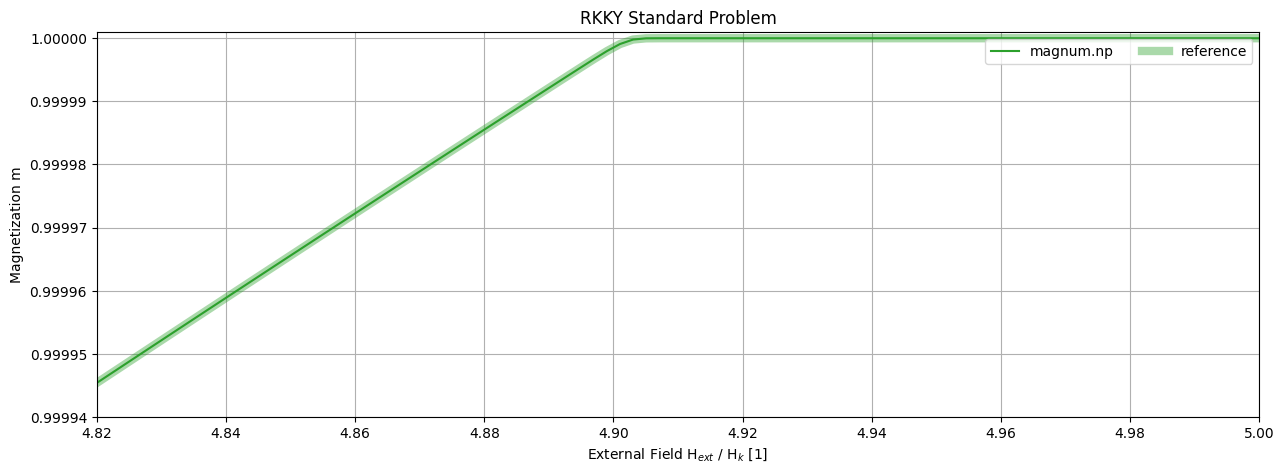

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data = np.loadtxt("data/log.dat")
ref = np.loadtxt("ref/log.dat")

Hk = 2 * 1e5 / 1.

fig, ax = plt.subplots(figsize=(15,5))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(data[:,6]/Hk, data[:,3], '-', color = cycle[2], label = "magnum.np")
ax.plot(ref[:,6]/Hk, ref[:,3], '-', color = cycle[2], linewidth = 6, alpha = 0.4, label = "reference")

ax.set_xlim([4.82,5.0])
ax.set_ylim([0.99994,1.000001])
ax.set_yticklabels(['0.99994', '0.99995', '0.99996', '0.99997', '0.99998', '0.99999', '1.00000'])
ax.set_title("RKKY Standard Problem")
ax.set_xlabel("External Field H$_{ext}$ / H$_k$ [1]")
ax.set_ylabel("Magnetization m")
ax.legend(ncol=3)
ax.grid()
fig.savefig("data/results.png")